In [1]:
import os
import glob
import numpy as np
import pandas as pd
from pytesseract import Output
import pytesseract 
import re
import torch
from torchvision import models, transforms, utils
from pathlib import Path
path = '/home/gpuadmin/shopdwg/A3_dataset'


In [2]:
from matplotlib import pyplot as plt
import cv2 as cv
import cv2


In [3]:

path = '/home/gpuadmin/shopdwg/A3_dataset/img_008.jpg'
img = cv.imread(path)
gray_scale = cv.cvtColor(img , cv.COLOR_BGR2GRAY)
_ , img_bin = cv.threshold(gray_scale , 150 , 225 , cv.THRESH_BINARY)
img_bin = ~img_bin

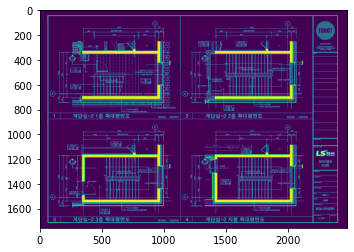

In [4]:
plt.imshow(img_bin)

In [5]:
print(img_bin.shape)

(1755, 2482)


In [331]:
import numpy as np 
line_min_width = 100
kernel_h = np.ones((1 ,line_min_width) , np.uint8)
kernel_v = np.ones((line_min_width , 1) , np.uint8) 


img_bin_h = cv.morphologyEx(img_bin ,  cv.MORPH_OPEN , kernel_h)
img_bin_v = cv.morphologyEx(img_bin , cv.MORPH_OPEN , kernel_v)

# img_bin_final = img_bin_h|img_bin_v
img_bin_final = img_bin_v | img_bin_h

In [332]:
final_kernel  = np.ones((3,3) , np.uint8)
img_bin_final = cv.dilate(img_bin_final , final_kernel , iterations = 1)

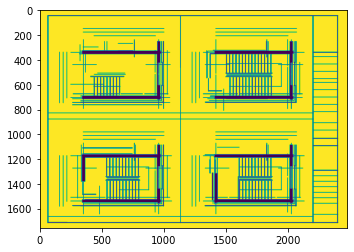

In [333]:
plt.imshow(~img_bin_final)

In [334]:
_ , labels  , stats , _ = cv.connectedComponentsWithStats(
~img_bin_final ,
connectivity = 8,
ltype = cv.CV_32S)

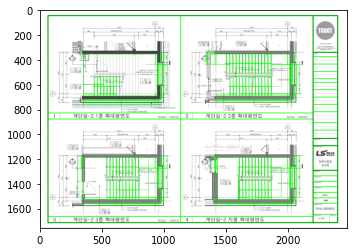

In [335]:
img = cv.imread(path)
for x,y,w,h, area in stats[:]:
    cv2.rectangle( img, (x,y) , (x+w , y+h) , (0,255) , 2)
plt.imshow(img)

In [359]:
new_stats = sorted(stats , key = lambda x : (x[0] + x[2]  , x[1] + x[3]))
left_bound = new_stats[-3][0]
img = cv2.imread(path)
graph = img[: , left_bound:]
text = pytesseract.image_to_data(graph)

In [379]:
new_stats

[array([ 305, 1175,   26,   96, 2496], dtype=int32),
 array([ 334, 1175,    4,   96,  384], dtype=int32),
 array([324, 332,  15,   7, 104], dtype=int32),
 array([324, 342,  15,   9, 135], dtype=int32),
 array([ 305, 1274,   43,  232, 8259], dtype=int32),
 array([ 351,  355,   14,   83, 1162], dtype=int32),
 array([ 351,  599,   83,   74, 6136], dtype=int32),
 array([ 351,  677,   83,   13, 1079], dtype=int32),
 array([ 437,  539,   23,   57, 1149], dtype=int32),
 array([440, 599,  20,  14, 280], dtype=int32),
 array([ 437,  616,   23,   74, 1455], dtype=int32),
 array([ 351, 1509,  127,   17, 1811], dtype=int32),
 array([ 351, 1549,  127,   23, 2543], dtype=int32),
 array([ 463,  539,   23,   57, 1149], dtype=int32),
 array([466, 599,  20,  14, 280], dtype=int32),
 array([ 466,  616,   20,   57, 1140], dtype=int32),
 array([463, 677,  23,  13, 263], dtype=int32),
 array([ 489,  539,   22,   57, 1092], dtype=int32),
 array([492, 599,  19,  14, 266], dtype=int32),
 array([ 492,  616,   1

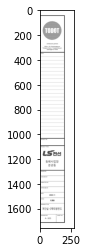

In [360]:
plt.imshow(graph)

In [365]:
list_result = re.findall(r'\b([A]-\w{1,3})\b', text)
split_data = text.split('\n')

In [362]:
print(list_result)

['A-305']


In [363]:
list_result = re.findall(r'\s[A-Z]-\d{1,3}', text)
split_data = text.split('\n')

In [366]:
image = cv.imread(path)
for data in split_data:
    if list_result[0] in data:
        index_data = data.split('\t')
        x , y , w , h , index = str(image.shape[1] - int(index_data[-4])) , str(image.shape[0] - int(index_data[-5])) , index_data[-3] , index_data[-2] , re.sub('[,.]' , '' ,  index_data[-1])
        
print(x , y , w , h, index)

2434 84 12 79 A-305


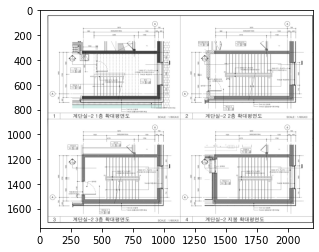

In [41]:
img = img[: , :left_bound]
plt.imshow(img)

In [5]:
class TemplateDataset(torch.utils.data.Dataset):
    def __init__(self, template_dir_path,image,thresh_csv=None, transform=None):
        self.transform = transform
        if not self.transform:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                )
            ])

        self.template_path = list(template_dir_path.iterdir())
        
        self.image = image
        self.thresh_df = None
        if transform:
            self.image = self.transform(self.image).unsqueeze(0)
      
        
        if thresh_csv:
            self.thresh_df = pd.read_csv(thresh_csv)
        
    def __len__(self):
        return len(self.template_path)
    
    def __getitem__(self, idx):
   
        template_path = str(self.template_path[idx])
        
        template = cv2.imread(template_path)
    
        if self.transform:
            template = self.transform(template)
            
        thresh = 0.7
        if self.thresh_df is not None:
            if self.thresh_df.path.isin([template_path]).sum() > 0:
                thresh = float(self.thresh_df[self.thresh_df.path==template_path].thresh)
        
        return {'image': self.image,  
                    'template' : template.unsqueeze(0),
                    'template_name' : template.path,
                    'image_h': template.size()[-2],
                   'image_w': template.size()[-1],
                   'thresh': thresh
                    }
        

In [385]:
from torch.utils.data import DataLoader
template_dir = '/home/gpuadmin/shopdwg/A3_dataset'
dataset = ImageDataset(Path(template_dir), None)
data_loader = DataLoader(dataset , batch_size = 1)


In [391]:
c = None
for i , data in enumerate(data_loader):
    print(data['image_name'] , data['draw_num'])
    c = data
    break

    
    

['A-305']
['/home/gpuadmin/shopdwg/A3_dataset/img_008.jpg'] ['A-305']


In [ ]:
import torch
import cv2
from pathlib import Path
from torchvision import models , transforms , utils
import re, pytesseract 
import numpy as np
import pandas as pd 

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, template_dir_path,thresh_csv=None, transform=None):
        self.transform = transform
        if not self.transform:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                )
            ])
        self.template_path = list(template_dir_path.iterdir())
        self.thresh_df = None
        self.image_path = 'sample/sample1.jpg'
        self.sample_image = self.transform(cv2.imread(self.image_path)).unsqueeze(0)
        
        if thresh_csv:
            self.thresh_df = pd.read_csv(thresh_csv)
        
    def __len__(self):
        return len(self.template_path)
    
    def __getitem__(self, idx):
   
        template_path = str(self.template_path[idx])
        image_raw = cv2.imread(template_path)
        
        image , draw_num = self.extract_draw_num(image_raw , template_path)
        
        if self.transform:
            image = self.transform(image)
            
        thresh = 0.7
        if self.thresh_df is not None:
            if self.thresh_df.path.isin([template_path]).sum() > 0:
                thresh = float(self.thresh_df[self.thresh_df.path==template_path].thresh)
                
                
        return {'image': image.unsqueeze(0), 
                    'image_raw': image_raw, 
                    'image_name': template_path, 
                    'image_h': image.size()[-2],
                   'image_w': image.size()[-1],
                   'thresh': thresh,
                   'draw_num' : draw_num,
                   'sample_image' : self.sample_image}
        
        
    def extract_draw_num(self , image , path):
        gray_scale = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
        _ , img_bin = cv2.threshold(gray_scale , 150 , 225 , cv2.THRESH_BINARY)
        img_bin = ~img_bin
        
        line_min_width = 100
        kernel_h = np.ones((1 ,line_min_width) , np.uint8)
        kernel_v = np.ones((line_min_width , 1) , np.uint8) 


        img_bin_h = cv2.morphologyEx(img_bin ,  cv2.MORPH_OPEN , kernel_h)
        img_bin_v = cv2.morphologyEx(img_bin , cv2.MORPH_OPEN , kernel_v)

        img_bin_final = img_bin_h|img_bin_v
        final_kernel  = np.ones((3,3) , np.uint8)
        img_bin_final = cv2.dilate(img_bin_final , final_kernel , iterations = 1) 
        
        _ , labels  , stats , _ = cv2.connectedComponentsWithStats(
                                                                ~img_bin_final ,
                                                                connectivity = 8,
                                                                ltype = cv2.CV_32S
                                                                )
          
        # new_stats = sorted(stats , key = lambda x : (x[0]  , x[1]))
        # left_bound = new_stats[-2][0]
        stats = sorted(stats , key = lambda x : (x[0] + x[2]  , x[1] + x[3]))

        left_bound = stats[-3][0]

        img = cv2.imread(path)

        graph = img[: , left_bound:]
        text = pytesseract.image_to_data(graph) 

        
        #list_result = re.findall(r'\s[A-Z]-\d{1,3}', text)
        list_result = re.findall(r'\b([A]-\w{1,3})\b', text)
        split_data = text.split('\n')

        if list_result:
            for data in split_data:
                if list_result[0] in data:
                    index_data = data.split('\t')
                    x , y , w , h , index = str(image.shape[1] - int(index_data[-4])) , str(image.shape[0] - int(index_data[-5])) , index_data[-3] , index_data[-2] , re.sub('[,.]' , '' ,  index_data[-1])
        else:
            index = 'None'
                
        crop_img = image[: , :left_bound]
  
        
        return crop_img , index
        #return crop_img , (x , y , w , h ,index)
                
        
        
        
        

In [ ]:
model = CreateModel(model=models.vgg19(pretrained=True).features, alpha=25, use_cuda=True)

image_dir = '/home/gpuadmin/shopdwg/A3_dataset'
template_dir = '/home/gpuadmin/shopdwg/QATM_pytorch-master/template'

images = ImageDataset(Path(image_dir))
image_loader = DataLoader(images , batch_size = 1)


def main():
    
    for index, image in enumerate(image_loader):
        
        draw_num = data['draw_num'][0]
        templates = TemplateDataset(
                                    Path(template_dir), 
                                    image['image'],  
                                    thresh_csv='thresh_template.csv'
                                    )
        scores, w_array, h_array, thresh_list = run_multi_sample(model, templates)
        boxes, indices = nms_multi(scores, w_array, h_array, thresh_list)
        
        image_raw = image['image_raw']
        d_img = plot_result_multi(image_raw[0].numpy(), boxes, indices, show=True, save_name='result_sample.png')
        
        
    
   